In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt
import pickle as pkl


### Load Data

Load csv.

Features are the emotions; the target variable is 'is_questionable'.

Ratain only users with at least one emotion.

Drop rows where "is_questionable" = NA.

In [ ]:
usr_emo_lean_path = os.path.join("..","..","data","processed","usr_emo_lean.gz")
ur_df = pd.read_csv(usr_emo_lean_path).dropna().query('n_emo > 0')
#ur_df

,Nome_Utente,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,n_comments,n_words,len_text,appropriate,inappropriate,offensive,violent,leaning,is_questionable,id,n_emo
2,# ATEL,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1,21,1,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,3,1
4,# COSEACASO,0.000000,1.00000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1,9,1,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,5,5
6,# ILCRI9,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,2,24,2,0.500000,0.500000,0.000000,0.000000,0.000000,0.0,7,1
7,# MiRiprendo la libertà,0.161290,0.16129,0.064516,0.129032,0.129032,0.258065,0.064516,0.129032,31,724,31,0.870968,0.000000,0.096774,0.032258,0.032258,0.0,8,8
8,# Nightmare#,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1,24,1,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323999,🍎Stark🍎,1.000000,0.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1,9,1,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,324000,3
324000,🎩CiaoRino! Club,0.105263,0.00000,0.000000,0.105263,0.157895,0.210526,0.052632,0.263158,19,625,19,0.684211,0.000000,0.315789,0.000000,0.052632,0.0,324001,6
324002,💞Luna🌈,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1,22,1,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,324003,2
324003,💡Fr@nz👣,0.083333,0.25000,0.000000,0.166667,0.375000,0.041667,0.166667,0.458333,24,783,24,0.833333,0.041667,0.125000,0.000000,0.250000,0.0,324004,7


Besides the thresholds, the summary contains:
- Number of accounts
- The percentage of 'Questionable' accounts
- Number of 'Questionable' accounts
- Number of correctly classified 'Questionable' accounts
- Number of accounts classified as 'Questionable'
- Precision and Recall

As the minimum number of comments decrases, the proportion of Questionable accounts decreases too.
And so do precision and recall.
The number of emotions involved impacts much less on precision and recall than minimum number of comments

Browse the results directory and plot the bar and beeswarm plots for each experiment.

In [18]:
shap_result_path = os.path.join("..","..","output","shap_results")
for i,dir in enumerate(os.listdir(shap_result_path)):
    if os.path.isdir(os.path.join(shap_result_path, dir)):
        print(dir)
        if dir == "plots":
            continue
        (min_comments, min_emo) = [int(dir.split('_')[j]) for j in [0,3] ]
        # select the SHAP with users of at least 8 comments and 1 emotion threshold
        if min_emo == 1 and min_comments == 8:
            df = ur_df.query("n_comments >= @min_comments and n_emo >= @min_emo")
            Y = np.where(df['is_questionable'].astype(int)>0,1,0)
            X = df[['anger','anticipation','disgust','fear','joy','sadness','surprise','trust']]
            # load shap values for the selected experiment
            with open(str(os.path.join(shap_result_path,dir,'shap.pkl')), 'rb') as f:
                my_shap_values = pkl.load(f)
            break


10_min_comments_1_min_emo_results
10_min_comments_2_min_emo_results
5_min_comments_1_min_emo_results
5_min_comments_2_min_emo_results
8_min_comments_1_min_emo_results


In [19]:
# Extract feature importance expressed as mean absolute shap value
plot_importance = pd.DataFrame({'Feature':X.columns, 'Importance':np.sum(np.mean(np.abs(my_shap_values), axis=1), axis=0)})
print(np.sum(np.mean(np.abs(my_shap_values), axis=1), axis=0))
print(X.columns)
plot_importance.sort_values('Importance', ascending=False)
print(plot_importance)
plot_importance.to_csv('../../output/plot_importance.csv', index=False)

[0.11789621 0.11441608 0.10093169 0.12126505 0.13050642 0.11966711
 0.10433023 0.1364107 ]
Index(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness',
       'surprise', 'trust'],
      dtype='object')
        Feature  Importance
0         anger    0.117896
1  anticipation    0.114416
2       disgust    0.100932
3          fear    0.121265
4           joy    0.130506
5       sadness    0.119667
6      surprise    0.104330
7         trust    0.136411


In [20]:
# function that modifies SHAP summary's colors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
def get_new_cmp(color01, color04):
    print(color01)
    print(color04)

    RGB_val = 255

    #color01 = (77, 146, 33)#color01= (0,150,200)  # Blue wanted
    #color04 = (197, 27, 125)#color04= (220,60,60)  # red wanted
    Colors = [color01, color04]

    # Creating a blue red palette transition for graphics
    Colors= [(R/RGB_val,G/RGB_val,B/RGB_val) for idx, (R,G,B) in enumerate(Colors)]
    n = 256

    # Start of the creation of the gradient
    Color01= ListedColormap(Colors[0], name='Color01', N=None)
    Color04= ListedColormap(Colors[1], name='Color04', N=None)
    top = cm.get_cmap(Color01,128)
    bottom = cm.get_cmap(Color04,128)
    newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                        bottom(np.linspace(0, 1, 128))))

    mymin0 = newcolors[0][0]
    mymin1 = newcolors[0][1]
    mymin2 = newcolors[0][2]
    mymin3 = newcolors[0][3]
    mymax0 = newcolors[255][0]
    mymax1 = newcolors[255][1]
    mymax2 = newcolors[255][2]
    mymax3 = newcolors[255][3]

    GradientBlueRed= [np.linspace(mymin0, mymax0,  n),
                    np.linspace(mymin1, mymax1,  n),
                    np.linspace(mymin2, mymax2,  n),
                    np.linspace(mymin3, mymax3,  n)]

    GradientBlueRed_res =np.transpose(GradientBlueRed)

    newcmp = ListedColormap(GradientBlueRed_res, name='BlueRed')
    return(newcmp)


In [21]:
# choose colors
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
w_high = widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='blue',
    disabled=False
)
w_low = widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='blue',
    disabled=False
)
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


In [28]:
#071a5d
w_high

ColorPicker(value='#071a5d', description='Pick a color')

In [29]:
#cedfeb
w_low

ColorPicker(value='#cedfeb', description='Pick a color')

In [40]:
len(my_shap_values[1])

25153

IndexError: index 25152 is out of bounds for axis 0 with size 25152

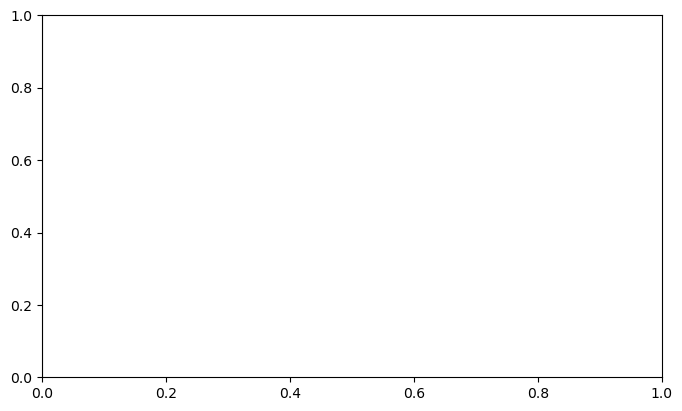

In [31]:
plt.figure()
shap.summary_plot(my_shap_values[1], X.values, feature_names = X.columns, show=False)
newcmp = get_new_cmp(hex_to_rgb(w_low.value), hex_to_rgb(w_high.value))
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(newcmp)
#plt.savefig("shap_summary.pdf",dpi=300)
#plt.savefig("shap_summary.png",dpi=300)

plt.show()
